<a href="https://colab.research.google.com/github/DiGyt/neuropynamics/blob/DiGyt_dev/NeuropynamicsToolbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Simulate biological networks of neurons*

##### Imports

For now, we only rely on numpy.

In [ ]:
import numpy as np

All other imports are only required for plotting.

In [ ]:
!pip install mne
import mne

import networkx as nx
import matplotlib.pyplot as plt

### Define Neuron, Dendrite, and Network models

In [ ]:
class IzhikevichNeuron():
  """Implementation of an Izhikevich Neuron."""

  def __init__(self, a=0.02, b=0.2, c=-65, d=8,
               dt=0.5, Vmax=35, V0=-65, u0=-14):
    # Initialize starting parameters for our neuron
    self.a = a
    self.b = b
    self.c = c
    self.d = d
    self.dt = dt
    self.Vmax = Vmax
    self.V = V0
    self.u = u0
    self.I = 0

  def __call__(self, I):
    """Simulate one timestep of our Izhikevich Model."""

    if self.V < self.Vmax:  # build up spiking potential
      # calculate the membrane potential
      dv = (0.04 * self.V + 5) * self.V + 140 - self.u
      V = self.V + (dv + self.I) * self.dt
      # calculate the recovery variable
      du = self.a * (self.b * self.V - self.u)
      u = self.u + self.dt * du
    
    else:  # spiking potential is reached
      V = self.c
      u = self.u + self.d

    # limit the spikes at Vmax
    V = self.Vmax if V > self.Vmax else V

    # assign the t-1 states of the model
    self.V = V
    self.u = u
    self.I = I
    return V


class Dendrite():
  """A dendrite-axon model capable of storing multiple action potentials over a
  course of time steps."""

  def __init__(self, weight=1, temp_delay=1):
    self.weight = weight
    self.temp_delay = temp_delay
    self.action_potentials = []

  def __call__(self, ap_input):
    """Simulate one time step for this dendrite."""

    # simulate the next timestep in the dendrite
    new_ap_state = []
    ap_output = 0
    for ap, t in self.action_potentials:
      # if the AP has travelled through the dendrite, return output
      if t == 0:
        ap_output += ap * self.weight
      # else countdown the timesteps for remaining APs in the dendrite
      else:
        new_ap_state.append((ap, t - 1))

    self.action_potentials = new_ap_state

    # enter a new AP into the dendrite
    if ap_input != 0:
      self.action_potentials.append((ap_input, self.temp_delay))

    return ap_output


class BNN():
  """A biological neural network connecting multiple neuron models."""

  def __init__(self, neurons, connections):
    self.neurons = neurons
    self.connections = connections
    self.neuron_states = np.zeros(len(neurons))

  def __call__(self, inputs=[0]):
    """Simulates one timestep in our BNN, while allowing additional external
    input being passed as a list of max length = len(BNN.neurons), where
    one inputs[i] corresponds to an action potential entered into BNN.neurons[i]
    at this timestep."""

    # add the external inputs to the propagated neuron inputs
    padded_inputs = np.pad(inputs, (0, len(self.neurons) - len(inputs)), 'constant')
    neuron_inputs = self.neuron_states + padded_inputs

    # process all the neurons
    #TODO: neuron outputs are atm represented as the deviation from their respective V0 value
    neuron_outputs = [neuron(i) - neuron.c for neuron, i in zip(self.neurons, neuron_inputs)]

    # update the future neuron inputs by propagating them through the connections
    neuron_states = np.zeros(len(self.neurons))
    for (afferent, efferent, connection) in self.connections:
      neuron_states[efferent] += connection(neuron_outputs[afferent])

    # we need to round in order to prevent rounding errors
    #neuron_states = np.round(neuron_states, 9)
    self.neuron_states = neuron_states

    return neuron_outputs

  # TODO: The plotting function is really ugly and should be redone.
  def plot(self, pos_func=nx.circular_layout, **kwargs):
    """A crude way of plotting the network, by transforming it to a networkX graph."""

    graph = nx.MultiDiGraph()
    graph.add_nodes_from([0, len(self.neurons) - 1])
    graph.add_edges_from([(eff, aff, connection.temp_delay) for aff, eff, connection in self.connections])
    
    pos = pos_func(graph)
    nx.draw_networkx_nodes(graph, pos, **kwargs)
    ax = plt.gca()
    for e in graph.edges:
        ax.annotate("",
                    xy=pos[e[0]], xycoords='data',
                    xytext=pos[e[1]], textcoords='data',
                    arrowprops=dict(arrowstyle="->", color="0.5",
                                    shrinkA=10, shrinkB=10,
                                    patchA=None, patchB=None,
                                    connectionstyle="arc3,rad=rrr".replace('rrr',str(0.05 + 0.1*e[2])),),)
    plt.axis('off')
    plt.show()

    




### Simulate Neurons and Dendrites

Start with simulating an Izhikevich Neuron

Text(0, 0.5, 'Voltage in mV')

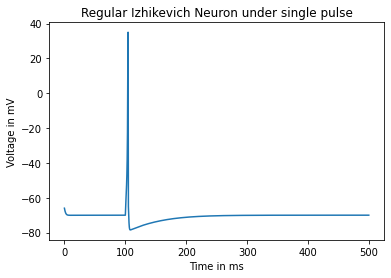

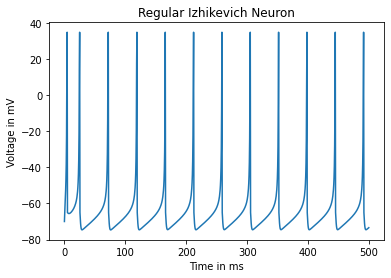

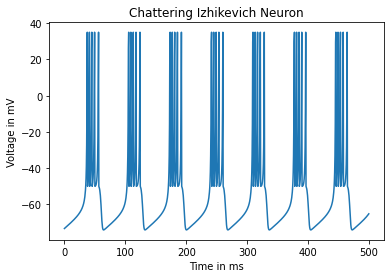

In [ ]:
# define the neuron
delta_time = 0.5  # step size in ms
neuron = IzhikevichNeuron(dt=0.5)

# define the simulation length (in timesteps of delta_time)
sim_steps = 1000
times = [t*delta_time for t in range(sim_steps)]


# plot a single impulse response
inputs = np.zeros(len(times))
inputs[200:210] = 10
plt.plot(times, [neuron(I=i) for i in inputs])
plt.title("Regular Izhikevich Neuron under single pulse")
plt.xlabel("Time in ms")
plt.ylabel("Voltage in mV")


# plot regular spiking
plt.figure()
plt.plot(times, [neuron(I=10) for t in times])
plt.title("Regular Izhikevich Neuron")
plt.xlabel("Time in ms")
plt.ylabel("Voltage in mV")


# plot chattering neuron
neuron.c=-50
neuron.d=2
plt.figure()
plt.plot(times, [neuron(I=10) for t in times])
plt.title("Chattering Izhikevich Neuron")
plt.xlabel("Time in ms")
plt.ylabel("Voltage in mV")

Get an intuition for how APs travel along the Dendrite

In [ ]:
dendrite = Dendrite(weight=1, temp_delay=5)

# print out the APs travelling through our dendrite
for ap in [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 2, 2, 3, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]:
  output = dendrite(ap)
  print(output, dendrite.action_potentials)

0 []
0 []
0 [(1, 5)]
0 [(1, 4), (1, 5)]
0 [(1, 3), (1, 4), (1, 5)]
0 [(1, 2), (1, 3), (1, 4), (1, 5)]
0 [(1, 1), (1, 2), (1, 3), (1, 4)]
0 [(1, 0), (1, 1), (1, 2), (1, 3)]
1 [(1, 0), (1, 1), (1, 2)]
1 [(1, 0), (1, 1)]
1 [(1, 0), (1, 5)]
1 [(1, 4)]
0 [(1, 3), (1, 5)]
0 [(1, 2), (1, 4)]
0 [(1, 1), (1, 3)]
0 [(1, 0), (1, 2)]
1 [(1, 1)]
0 [(1, 0)]
1 [(1, 5)]
0 [(1, 4), (1, 5)]
0 [(1, 3), (1, 4), (2, 5)]
0 [(1, 2), (1, 3), (2, 4), (2, 5)]
0 [(1, 1), (1, 2), (2, 3), (2, 4), (3, 5)]
0 [(1, 0), (1, 1), (2, 2), (2, 3), (3, 4), (3, 5)]
1 [(1, 0), (2, 1), (2, 2), (3, 3), (3, 4), (2, 5)]
1 [(2, 0), (2, 1), (3, 2), (3, 3), (2, 4), (1, 5)]
2 [(2, 0), (3, 1), (3, 2), (2, 3), (1, 4)]
2 [(3, 0), (3, 1), (2, 2), (1, 3)]
3 [(3, 0), (2, 1), (1, 2)]
3 [(2, 0), (1, 1)]
2 [(1, 0)]
1 []
0 []
0 []
0 []
0 []
0 []


### Simulate a full network

First, we generate a Network Model and visualize it.

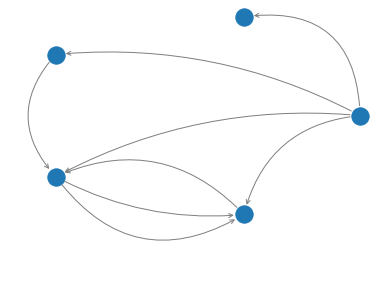

In [ ]:
# define a network model, created from 5 connected Izhikevich Neurons
bnn = BNN(neurons=[IzhikevichNeuron() for i in range(5)],
          connections=[(0, 1, Dendrite()),
                       (0, 2, Dendrite(weight=0.5)),
                       (0, 3, Dendrite(temp_delay=3)),
                       (0, 4, Dendrite(temp_delay=5)),
                       (1, 2, Dendrite(weight=0.8, temp_delay=4)),
                       (2, 3, Dendrite(temp_delay=1)),
                       (2, 3, Dendrite(temp_delay=4)),
                       (3, 2, Dendrite(weight=0.3, temp_delay=3))])

bnn.plot()

Run the network without any inputs for 1000 timesteps.
Optimally, the neurons should show no outputs.

In [ ]:
timesteps=1000
state_log = np.empty([len(bnn.neurons), timesteps])
for i in range(timesteps):
  neuron_states = bnn()
  state_log[:, i] = neuron_states

Plot the outputs of each neuron, using the MNE Toolbox for neurophysiological data analysis.

Creating RawArray with float64 data, n_channels=5, n_times=1000
    Range : 0 ... 999 =      0.000 ...     0.499 secs
Ready.


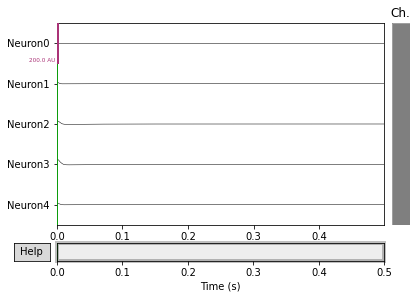

In [ ]:
info = mne.create_info(ch_names=["Neuron0", "Neuron1",
                                 "Neuron2", "Neuron3",
                                 "Neuron4"], sfreq=1000/0.5)
data = mne.io.RawArray(state_log, info)
d = data.plot(scalings=dict(misc=1e2))

Simulate the data again, but inducing a short voltage burst of 10 mV into the first Neuron after 100 ms

Creating RawArray with float64 data, n_channels=5, n_times=2000
    Range : 0 ... 1999 =      0.000 ...     1.000 secs
Ready.


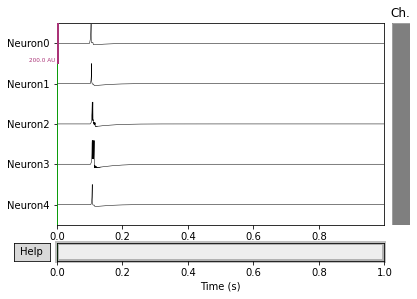

In [ ]:
# give input to the first neuron
n_times = 2000
inputs = np.zeros([n_times, 1])
inputs[200:220] = 10

state_log = np.empty([len(bnn.neurons), n_times])
for ind, current in enumerate(inputs):
  neuron_states = bnn(current)
  state_log[:, ind] = neuron_states

# plot it
info = mne.create_info(ch_names=["Neuron0", "Neuron1",
                                 "Neuron2", "Neuron3",
                                 "Neuron4"], sfreq=1000/0.5)
data = mne.io.RawArray(state_log, info)
d = data.plot(scalings=dict(misc=1e2))

### Implement an Example for dendritic computation given in the lecture

Dendritic computation for localisation of auditory cues

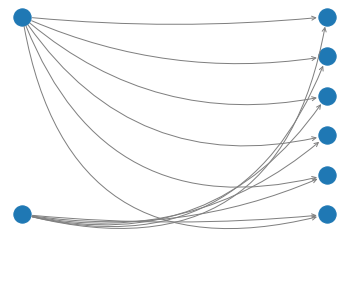

In [ ]:
# define the model. 0 is a neuron input from the left, 1 from the right
# the rest are response neurons
response_ns = 6
connections_0 = [(0, i + 2, Dendrite(weight=0.7, temp_delay=i)) for i in range(response_ns)]
connections_1 = [(1, i + 2, Dendrite(weight=0.7, temp_delay=response_ns-1-i)) for i in range(response_ns)]
bnn = BNN(neurons=[IzhikevichNeuron() for i in range(response_ns + 2)],
          connections= connections_0 + connections_1)

bnn.plot(pos_func=lambda x:nx.bipartite_layout(x, nodes=[0,1]))

Run and plot the simulation

Creating RawArray with float64 data, n_channels=8, n_times=80
    Range : 0 ... 79 =      0.000 ...     0.040 secs
Ready.


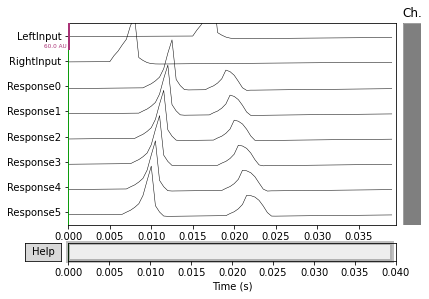

In [ ]:
# decide at which milisecond the input neurons receive inputs
input_left = 15
input_right = 5

# initialize the inputs
n_times = 80
dt = 0.5  # ms
inputs = np.zeros([n_times, 2], dtype=np.float64)
inputs[int(input_left/dt):int(input_left/dt)+3, 0] = 30
inputs[int(input_right/dt):int(input_right/dt)+3, 1] = 30

# run the simulation
states = np.zeros([len(bnn.neurons), n_times])
for ind, current in enumerate(inputs):
  neuron_states = bnn(current)
  states[:, ind] = neuron_states

# plot it
info = mne.create_info(ch_names=["LeftInput", "RightInput"] + ["Response"+str(i) for i in range(response_ns)],
                       sfreq=1000/dt)
data = mne.io.RawArray(states, info)
d = data.plot(scalings=dict(misc=3e1))

### Check timing for larger networks

Full frenzy!

In [ ]:
# dynamically define a big Izhikevich Neuron network
n_neurons = 5000
n_connections = 7500
bnn = BNN(neurons=[IzhikevichNeuron() for i in range(n_neurons)],
          connections=[(np.random.randint(0, n_neurons),
                        np.random.randint(0, n_neurons),
                        Dendrite(weight=0.2, temp_delay=np.random.randint(0, 20))) for i in range(n_connections)])

plot the network graph. Yes, this is a network graph ;)

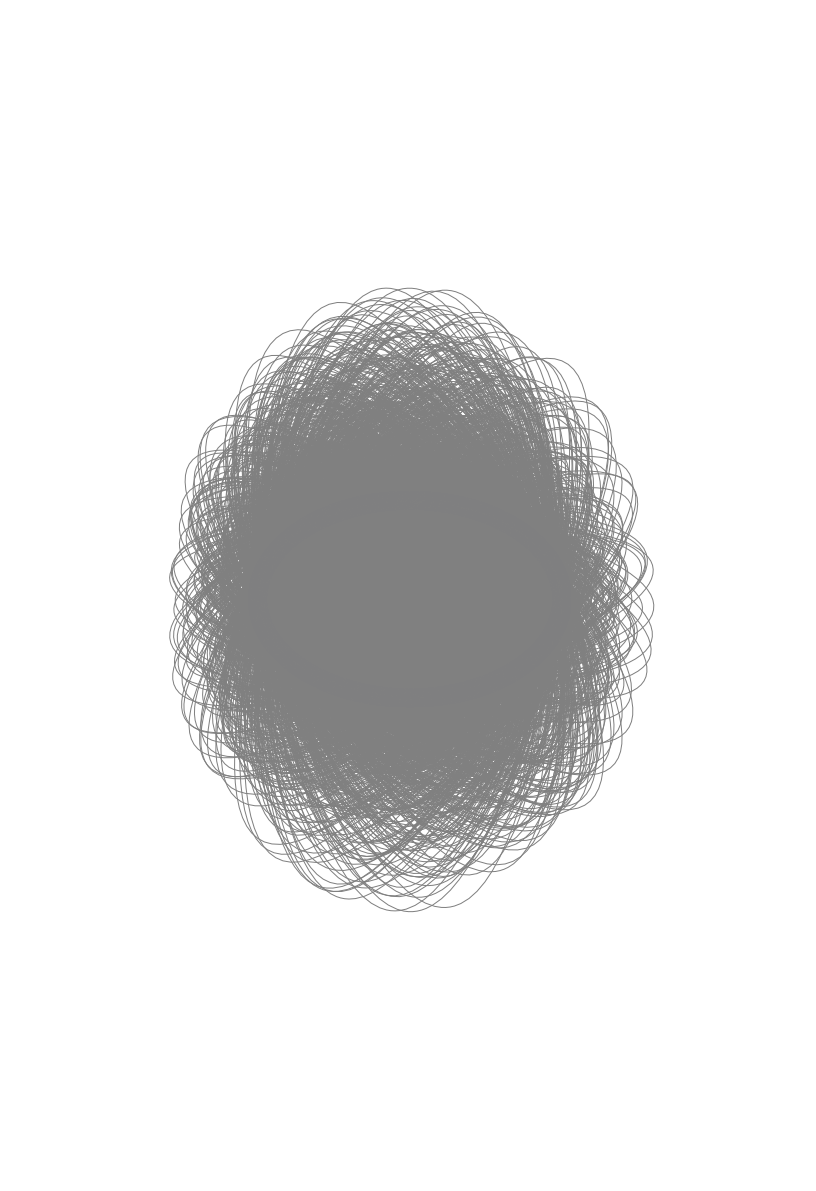

In [ ]:
bnn.plot()

Now simulate a single impulse again...

In [ ]:
# give input to the first neuron
n_times = 2000
inputs = np.zeros([n_times, 2])
inputs[200:220] = 10

state_log = np.empty([len(bnn.neurons), n_times])
for ind, current in enumerate(inputs):
  neuron_states = bnn(current)
  state_log[:, ind] = neuron_states

...and plot it...

Creating RawArray with float64 data, n_channels=5000, n_times=2000
    Range : 0 ... 1999 =      0.000 ...     1.000 secs
Ready.


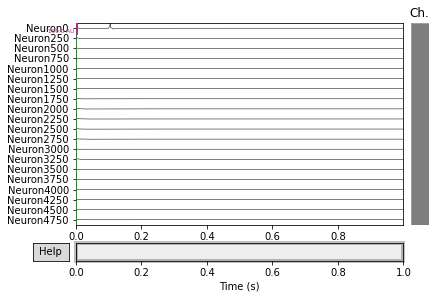

In [ ]:
# plot it
info = mne.create_info(ch_names=["Neuron{0}".format(i) for i in range(len(bnn.neurons))],
                       sfreq=1000/0.5)
data = mne.io.RawArray(state_log, info)
data.pick_channels(["Neuron{}".format(int(i)) for i in range(0, 5000, 250)])
d = data.plot(scalings=dict(misc=5e1))

Todos:

How to deal with voltage entering the axons? propagate actual voltage or AP (voltage difference from -70 mV)?

Neuron models: Pass parameters a,b,c,d as attributes of the neuron or as parameters for the function? function parameters can be more easily changed for simulating single neurons, neuron obj attributes can be more easily changed during simulating entire networks (+ are more theoretically valid?)

Axon/Dendrite Models. Can we use more sophisticated models?